In [228]:
import numpy as np
import pandas as pd
import math
import itertools as iter
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTENC
from numpy.random import RandomState

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import graphviz 
from xgboost import XGBClassifier

In [194]:
# Import data
data = pd.read_csv("data/train.csv")
# Keeping observations that are only for heads of household
data = data[data["parentesco1"] == 1]

# Changing the classification to start from 1
data["Target"] = data["Target"] - 1

In [195]:
# Function to identify missing columns from the Costa Rica data
def per_missing(data):
    cols = {}
    for col in data:
        data[data[col] == np.nan] = pd.NA
        cols[col] = getattr(data, col).isna().sum() / len(data)

    return sorted(cols.items(), key = lambda x: x[1])

missing_rates = per_missing(data)

In [196]:
# Drop columns with any missing data
columns_w_missing_data = [var[0] for var in missing_rates if var[1] != 0]
print("Dropping the following columns because of missing data:\n", columns_w_missing_data)

data = data.drop(columns=[var[0] for var in missing_rates if var[1] != 0])

Dropping the following columns because of missing data:
 ['meaneduc', 'SQBmeaned', 'v2a1', 'v18q1', 'rez_esc']


In [197]:
# Dropping additional variables due to irrelevance
# Removing id variables: ID and idhogar
# Removing dependency because of incosistency with labelling
# Removing "edjefe", "edjefa" because of inconsitency in labelling (int vs str)
# SQBage and agesq are the same, removing agesq
# Removing SQBage because creating a threshold value is costly given the number of unique values. Also is not expected to be meaningful
data["dependency"] = data["SQBdependency"] ** .5
data = data.drop(columns=[
    "Id", "idhogar", "edjefe", "edjefa",
    "agesq", "tamhog", "hogar_total", "SQBage", "SQBescolari",
    "SQBedjefe", "SQBdependency", "SQBhogar_nin", "SQBovercrowding",
    "SQBhogar_total"
])


In [198]:
X = data.iloc[:, :-1]
y = data.iloc[:, -1]
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=69420)
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.125, random_state=42069)

In [199]:
data["Target"].value_counts(normalize=True)

Target
3    0.657249
1    0.148671
2    0.119408
0    0.074672
Name: proportion, dtype: float64

In [200]:
def find_categorical_columns(data):
    categorical_columns = []
    for idx, col in enumerate(data.columns):
        unique_vals = data[col].unique()
        if len(unique_vals) <= 4:
            categorical_columns.append(idx)
    return categorical_columns

In [531]:
def create_sampling_strat_dict(c_0, c_1, c_2, c_3):
    """
    Creates a dictionary containing the number of observations that should be
    in each class category. Because the most common class label is 3 and because
    with oversampling with SMOTENC we can't sample a group at lower than the cuurent
    n, we decide the overall n (and subsequenct class sizes) based on the current
    number observations assigned to class label 3.
    """
    label_3_n = len(train_y[train_y == 3])
    n = label_3_n / c_3
    sampling_dict = {
        0: round(c_0 * n),
        1: round(c_1 * n),
        2: round(c_2 * n),
        3: label_3_n
    }

    return sampling_dict


sm = SMOTENC(random_state=69420,
             categorical_features=find_categorical_columns(X), 
             sampling_strategy=create_sampling_strat_dict(.45,.25,.2,.1))
sm

SMOTENC(categorical_features=[0, 2, 3, 4, 5, 18, 19, 20, 21, 22, 23, 24, 25, 26,
                              27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
                              39, 40, 41, 42, ...],
        random_state=69420,
        sampling_strategy={0: 6147, 1: 3415, 2: 2732, 3: 1366})

In [532]:
x_resample, y_resample = sm.fit_resample(train_x,
                                         train_y)

In [533]:
y_resample.value_counts(normalize=True)

Target
0    0.45
1    0.25
2    0.20
3    0.10
Name: proportion, dtype: float64

In [534]:
# Round dependcy vairables. numeircal instability created from the oversampling process
x_resample["dependency"] = np.round(x_resample["dependency"], 1)
x_resample["overcrowding"] = np.round(x_resample["overcrowding"], 1)


In [204]:
def entropy(input):
    """
    Returns the entropy in the labels for the data points in ids.
    
    :@param y: all labels
    :@param ids: the indexes of data points
    """

    probs = input["Target"].value_counts(normalize=True)
    return (-probs * np.log2(probs)).sum()

def information_gain(input, x):
    """
    Returns the information gain by splitting root into left child and right child.
    
    :@param y: all labels
    """
    unique_values = input[x].unique()

    val_probs = input[x].value_counts(normalize=True)
    val_entropy = 0

    for val in unique_values:
        val_entropy += val_probs[val] * entropy(input.loc[input[x] == val])

    return entropy(input) - val_entropy

In [535]:
def find_thresholds(input):
    categorical_columns = find_categorical_columns(input)

    # counter = 0
    thresholds = {}
    for idx, col in enumerate(input.columns):
        if idx not in categorical_columns:
            print(col)
            unique_vals = input[col].unique()

            best_ig = 0
            best_thresh = None

            for lower_bound, upper_bound in iter.permutations(unique_vals, 2):
                if upper_bound < lower_bound:
                    continue

                alternative_data = input.copy()
                alternative_data.loc[alternative_data[col] < lower_bound, col] = 0
                alternative_data.loc[(alternative_data[col] >= lower_bound) & (alternative_data[col] < upper_bound), col] = 1
                alternative_data.loc[alternative_data[col] >= upper_bound, col] = 2

                ig = information_gain(alternative_data, col)
                if ig > best_ig:
                    best_ig = ig 
                    best_thresh = [lower_bound, upper_bound]

            thresholds[col] = best_thresh

            # counter += 1
            # if counter == 30:
            #     return thresholds
    
    return thresholds

continuous_thresholds = find_thresholds(pd.concat([x_resample, y_resample], axis=1))
                

rooms
r4h1
r4h2
r4h3
r4m1
r4m2
r4m3
r4t1
r4t2
r4t3
tamviv
escolari
hhsize
hogar_nin
hogar_adul
dependency
bedrooms
overcrowding
qmobilephone
age


In [536]:
continuous_thresholds

{'rooms': [5, 6],
 'r4h1': [2, 4],
 'r4h2': [2, 3],
 'r4h3': [1, 2],
 'r4m1': [1, 2],
 'r4m2': [2, 4],
 'r4m3': [2, 5],
 'r4t1': [1, 3],
 'r4t2': [3, 4],
 'r4t3': [2, 4],
 'tamviv': [2, 4],
 'escolari': [11, 16],
 'hhsize': [2, 4],
 'hogar_nin': [2, 4],
 'hogar_adul': [2, 4],
 'dependency': [1.1, 8.0],
 'bedrooms': [3, 4],
 'overcrowding': [0.6, 1.6],
 'qmobilephone': [1, 3],
 'age': [29, 68]}

In [537]:
#Updating datasets with optimal thresholds based on information gain
for dataset in [x_resample, valid_x, test_x]:
    for col, thresholds in continuous_thresholds.items():
        dataset.loc[dataset[col] < thresholds[0], col] = 1
        dataset.loc[(dataset[col] >= thresholds[0]) & (dataset[col] < thresholds[1]), col] = 2
        dataset.loc[dataset[col] >= thresholds[1], col] = 3

In [538]:
x_resample

,hacdor,rooms,hacapo,v14a,refrig,v18q,r4h1,r4h2,r4h3,r4m1,...,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age
0,0,3,0,1,1,0,1,2,3,3,...,2,0,1,0,0,0,0,1,0,2
1,0,2,0,1,1,0,1,2,3,3,...,3,0,0,0,1,0,0,1,0,3
2,0,1,0,1,1,0,1,1,3,3,...,2,1,0,0,0,0,0,1,0,1
3,0,3,0,1,1,1,1,1,3,3,...,3,1,0,0,0,0,0,1,0,2
4,0,2,0,1,1,0,1,3,3,3,...,3,1,0,0,0,0,0,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13655,0,1,0,1,1,0,1,1,3,3,...,2,0,0,0,0,0,0,0,1,2
13656,0,2,0,1,1,0,1,2,3,3,...,2,1,0,0,0,0,0,0,1,2
13657,0,2,0,1,1,0,2,1,3,3,...,2,1,0,0,0,0,0,1,0,2
13658,0,1,0,1,1,0,1,1,3,3,...,3,1,0,0,0,0,0,1,0,2


In [539]:
basic_tree = tree.DecisionTreeClassifier(max_depth=10, criterion="log_loss")
basic_tree = basic_tree.fit(x_resample, y_resample)
dot_data = tree.export_graphviz(basic_tree, out_file=None,
                                feature_names=x_resample.columns,
                                filled=True, rounded=True,special_characters=True)
graph = graphviz.Source(dot_data) 
graph.render("tree")

'tree.pdf'

In [540]:
basic_tree.score(test_x, test_y)

0.29747899159663865

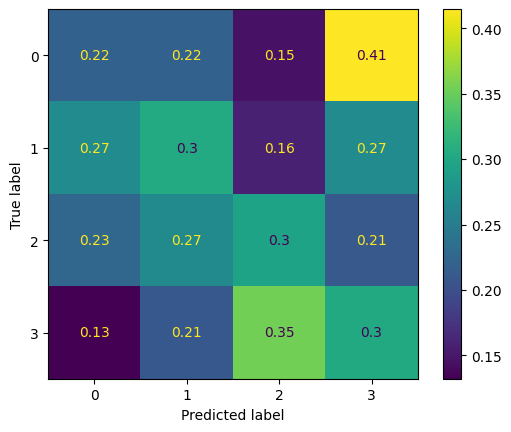

In [541]:
y_prediction = basic_tree.predict(test_x)
disp = metrics.ConfusionMatrixDisplay(
    confusion_matrix=metrics.confusion_matrix(test_y, y_prediction, normalize='true'))
disp.plot()

In [542]:
big_forest = RandomForestClassifier(max_depth=8, n_estimators=500,
                                    criterion="log_loss")
big_forest.fit(x_resample, y_resample)
big_forest.score(test_x, test_y)

0.38823529411764707

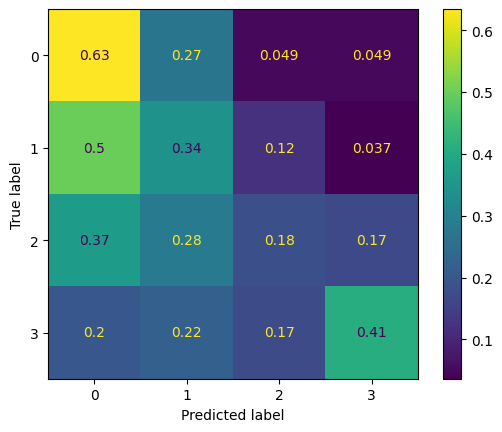

In [543]:
y_prediction = big_forest.predict(test_x)
disp = metrics.ConfusionMatrixDisplay(
    confusion_matrix=metrics.confusion_matrix(test_y, y_prediction, normalize='true'))
disp.plot()

In [568]:
#Create binary classificaiton
y_resample_binary, test_y_binary = y_resample.copy(), test_y.copy()

for d in [y_resample_binary, test_y_binary]:
    d.loc[d.isin([0,1])] = 0
    d.loc[d.isin([2,3])] = 1

big_forest = RandomForestClassifier(max_depth=10, n_estimators=1000,
                                    criterion="log_loss")
big_forest.fit(x_resample, y_resample_binary)
big_forest.score(test_x, test_y_binary)

0.6722689075630253

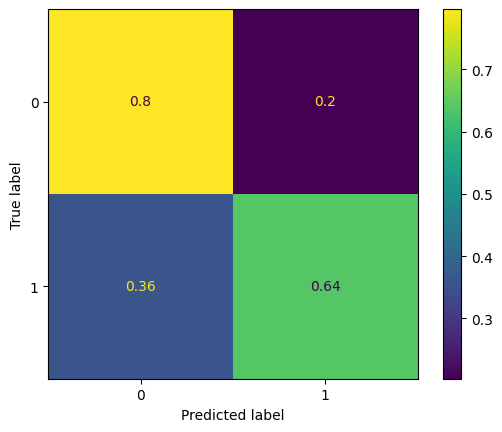

In [569]:
y_prediction = big_forest.predict(test_x)
disp = metrics.ConfusionMatrixDisplay(
    confusion_matrix=metrics.confusion_matrix(test_y_binary, y_prediction, normalize='true'))
disp.plot()

In [413]:
XTREME_forest = XGBClassifier(max_depth=10, learning_rate=1,
                              num_parallel_tree = 100,
                              objective='multi:softprob',
                              eval_metric = 'mlogloss')
XTREME_forest.fit(x_resample, y_resample)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=200, objective='multi:softprob', ...)

In [420]:
print("The accuracy of the XGradient Boost is",
      XTREME_forest.score(test_x, test_y))
y_prediction = XTREME_forest.predict(test_x)

print("The F1 score of the XGradient Boost is",
      metrics.f1_score(test_y, y_prediction, average = "weighted"))

The accuracy of the XGradient Boost is 0.6168067226890757
The F1 score of the XGradient Boost is 0.590757085496789


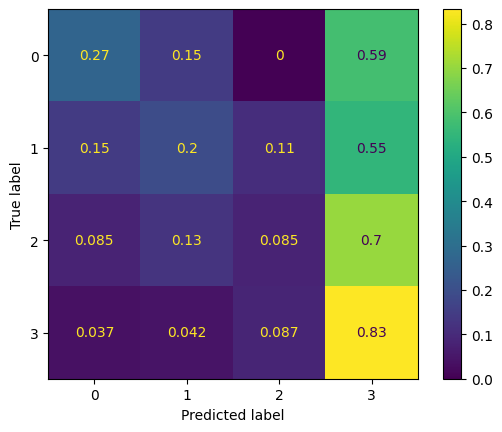

In [424]:
disp = metrics.ConfusionMatrixDisplay(
    confusion_matrix=metrics.confusion_matrix(test_y, y_prediction, normalize='true'))
disp.plot()

In [286]:
XTREME_forest_alt = XGBClassifier(max_depth=100, learning_rate=1,
                              num_parallel_tree = 5,
                              objective='multi:softprob',
                              eval_metric = 'mlogloss')
XTREME_forest_alt.fit(train_x, train_y)
XTREME_forest_alt.score(test_x, test_y)

0.32605042016806723

In [572]:
from sklearn.neural_network import MLPClassifier
nn = MLPClassifier(solver='adam',
                   alpha=1e-5,
                   hidden_layer_sizes=(100, 20, 4),
                   random_state=1,
                   learning_rate='adaptive',
                   activation="relu",
                   shuffle= True,
                   max_iter= 300)

nn.fit(x_resample, y_resample)
nn.score(test_x, test_y)

0.7025210084033613

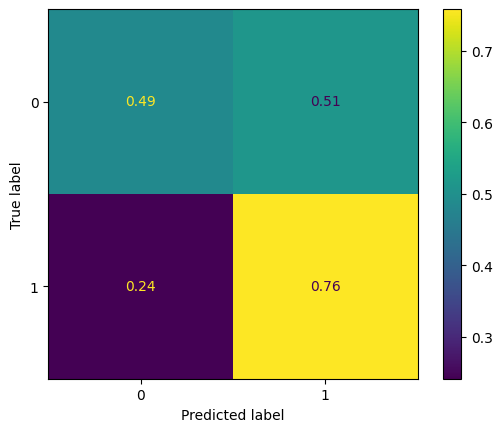

In [573]:
y_prediction = nn.predict(test_x)
disp = metrics.ConfusionMatrixDisplay(
    confusion_matrix=metrics.confusion_matrix(test_y, y_prediction, normalize='true'))
disp.plot()